In [1]:
import numpy as np
from scipy.io.idl import readsav
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
#mpl.use('macosx')
#sns.set()

# Integrating away the MinXSS data denominators

We'll define some functions to handle integrating across the MinXSS science data, which are in photons / s / cm2 / keV. These first two functions will remove the /keV and /s, respectively. Then we create a function to account for the fact that we took these measurements at 1 AU, which gets rid of the /cm2.

In [40]:
def integrate_spectrum_energy(spectral_irradiance, energy):
    #energy_threshold = 1.5  # [keV]; below this, data is noise-dominated
    #spectral_irradiance = spectral_irradiance[:, energy > energy_threshold]
    #energy = energy[energy > energy_threshold]
    irradiance_masked = np.ma.array(spectral_irradiance, mask=np.isnan(spectral_irradiance))  # Causes the units to get dropped
    return np.trapz(irradiance_masked, energy)


def integrate_spectrum_time(irradiance, time_jd):
    time_seconds = (time_jd - time_jd[0]) * 86400 * u.second
    return np.trapz(irradiance, time_seconds)


def integrate_photon_flux_1au(fluxes):
    return [flux * 4 * np.pi * ((1*u.AU).to(u.cm))**2 for flux in fluxes]

# Histograming functions

compute_ffd computes the flare frequency distribution for whatever kind of array you pass it. It could be the data that's been integrated every which way so that it's just in ergs. It could leave some integrations out, leaving with erg/s, for example. We also define a function that'll just fit a slope over the histogram, and plot over the most recent plot. We restrict the xrange that the fit is applied to, and provide some default parameters for that.

In [3]:
def compute_ffd(measurement_array):
    log_bins = np.geomspace(measurement_array.min(), measurement_array.max(), 30)
    bin_centers = np.sqrt(log_bins[1:] * log_bins[:-1])
    
    # Count number of flares in each bin: N
    hist = np.histogram(measurement_array, bins=log_bins)
    n = hist[0]
    
    # Divide each N by its corresponding bin value
    dn_dbin = n / bin_centers
    
    # Divide all bins by the duration of observations in years
    observation_duration_years = (minxsslevel1['time'][-1]['jd'] - minxsslevel1['time'][0]['jd']) / 365.25
    return bin_centers, dn_dbin / observation_duration_years

def plot_ffd_basic(bin_centers, y, number_of_points):
    plt.figure(figsize=(10,6))
    plt.step(bin_centers, y)
    plt.xscale('log')
    plt.yscale('log')
    plt.title('N = {}'.format(num_events))

def fit_slope(x, y, xmin=2e30, xmax=1e32):
    mask = (x >= xmin) & (x <= xmax) & (y > 0)
    logx = np.log10(x[mask])
    logy = np.log10(y[mask])
    p = np.polyfit(logx, logy, deg=1) #, w = 1./(energy_uncertainty**2)
    xfit = np.logspace(np.round(np.log10(xmin)), np.round(np.log10(xmax)), num=30)
    line = 10**p[1] * xfit ** p[0]
    plt.plot(xfit, line)
    plt.annotate('$\\alpha$ = {0:.2f}'.format(p[0]), xy=(0.5, 0.95), xycoords='axes fraction', fontsize=14, horizontalalignment='center')

# Convenience functions

In [4]:
def extract_time_jd(minxsslevel1):
    return np.array([minxsslevel1['time'][i]['jd'][0] for i in range(len(minxsslevel1))])

def minxss_near_flare_peak(minxss_time_jd, goes_peak_time_jd, tolerance_pm_minutes=5):
    tolerance_fraction_of_day = tolerance_pm_minutes / 1440
    array = np.asarray(minxss_time_jd)
    idx = (np.abs(minxss_time_jd - goes_peak_time_jd)).argmin()
    if np.abs(minxss_time_jd[idx] - goes_peak_time_jd) <= tolerance_fraction_of_day:
        return idx
    else:
        return np.nan

def convert_photons_to_energy(energy, photons):
    energy_erg = u.keV.to(u.erg, energy) * u.erg
    mean_energy = np.ma.array(energy_erg, mask=(energy_erg < 0)).mean() / u.photon
    return [photon * mean_energy for photon in photons] 

# Read data

In [25]:
%%time
data_path = '/Users/jmason86/Dropbox/minxss_dropbox/data/fm1/level1/'
data = readsav('{}minxss1_l1_mission_length_v2.sav'.format(data_path))
minxsslevel1 = data.minxsslevel1.x123[0].copy()
spectral_irradiance = np.stack(minxsslevel1['irradiance']) * (u.photon / u.second / u.centimeter**2 / u.keV)
energy = minxsslevel1[0]['energy']
time_jd = extract_time_jd(minxsslevel1)

goes_events_path = '/Users/jmason86/Dropbox/Research/Data/GOES/events/'
data_goes = readsav('{}GOES_events_MinXSS1_era.sav'.format(goes_events_path))
goes_events = data_goes.goesevents.copy()
goes_start_jd = goes_events['eventstarttimejd']
goes_peak_jd = goes_events['eventpeaktimejd']
goes_end_jd = goes_start_jd + 1/24  # Nearly all flares are << 1 hour. The post-flare time intensity is much smaller and will add little to the time-integrated value

CPU times: user 20.6 s, sys: 1.52 s, total: 22.1 s
Wall time: 22.2 s


# Preflare subtraction

In [41]:
# Integrate spectra across energy to produce one value per time
irradiance = integrate_spectrum_energy(spectral_irradiance, energy) * (u.photon / u.second / u.centimeter**2)

# Calculate pre-flare irradiance
preflare_time_window = 300/1440  # [fraction of day units]; From Mason et al. 2019 (JEDI paper I), "the optimal window duration is 300 minutes"
preflare_irradiance = []
good_event_indices = []
for i in range(len(goes_start_jd)):
    preflare_indices = np.where((time_jd >= (goes_start_jd[i] - 300/1440)) & (time_jd <= goes_start_jd[i]))
    if preflare_indices[0].size > 1:
        preflare_irradiance.append(np.median(irradiance[preflare_indices]))
        good_event_indices.append(i)

In [42]:
# Integrate across the flare times
photon_fluxes = []
j = 0
for i in good_event_indices:
    flare_time_indices = np.where((time_jd >= goes_start_jd[i]) & (time_jd <= goes_end_jd[i]))
    if flare_time_indices[0].size > 1:
        irradiance_preflare_subtracted = irradiance[flare_time_indices] - preflare_irradiance[j]
        photon_fluxes.append(integrate_spectrum_time(irradiance_preflare_subtracted, time_jd[flare_time_indices]))       
    j+=1

In [43]:
# Integrate over 1 AU to get rid of the / cm^2
photons = integrate_photon_flux_1au(photon_fluxes)

In [44]:
# Convert photons to energy
measured_energy = convert_photons_to_energy(energy, photons)
measured_energy_array = np.array([m.value for m in measured_energy])
num_events = len(measured_energy_array)

In [45]:
# Get histogram
bin_centers, dn_de_per_year = compute_ffd(measured_energy_array)

/Users/jmason86/anaconda3/envs/minxss_ffd/lib/python3.7/site-packages/numpy/core/function_base.py:418: RuntimeWarning: invalid value encountered in log10
  log_start = _nx.log10(start)
/Users/jmason86/anaconda3/envs/minxss_ffd/lib/python3.7/site-packages/numpy/lib/histograms.py:433: RuntimeWarning: invalid value encountered in greater
  if np.any(bin_edges[:-1] > bin_edges[1:]):


In [46]:
log_bins = np.geomspace(measured_energy_array.min(), measured_energy_array.max(), 30)

In [47]:
log_bins

array([           nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan,            nan,            nan,            nan,
                  nan, 3.27132092e+30])

In [ ]:
# Plot histogram and power law fit
plot_ffd_basic(bin_centers, dn_de_per_year, len(measured_energy_array))
plt.xlabel('SXR solar flare energy (preflare subtracted) [erg]')
plt.ylabel('dN/dE per year')
fit_slope(bin_centers, dn_de_per_year)
plt.savefig('plots/Total flare energy per year preflare subtracted.png')

# Histograms

## Histogram of dN/dE per year vs energy [erg]

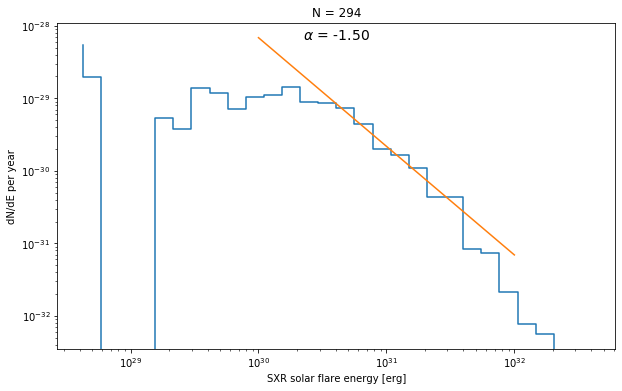

In [38]:
# Integrate spectra across energy to produce one value per time
irradiance = integrate_spectrum_energy(spectral_irradiance, energy) * (u.photon / u.second / u.centimeter**2)

# Integrate across the times of all flares identified by GOES
photon_fluxes = []
for i in range(len(goes_start_jd)):
    flare_time_indices = np.where((time_jd >= goes_start_jd[i]) & (time_jd <= goes_end_jd[i]))
    if flare_time_indices[0].size > 1:
        photon_fluxes.append(integrate_spectrum_time(irradiance[flare_time_indices], time_jd[flare_time_indices]))

# Integrate over 1 AU to get rid of the / cm^2
photons = integrate_photon_flux_1au(photon_fluxes)

# Convert photons to energy
measured_energy = convert_photons_to_energy(energy, photons)
measured_energy_array = np.array([m.value for m in measured_energy])
num_events = len(measured_energy_array)

# Get histogram
bin_centers, dn_de_per_year = compute_ffd(measured_energy_array)

# Plot histogram and power law fit
plot_ffd_basic(bin_centers, dn_de_per_year, len(measured_energy_array))
plt.xlabel('SXR solar flare energy [erg]')
plt.ylabel('dN/dE per year')
fit_slope(bin_centers, dn_de_per_year)
plt.savefig('plots/Total flare energy per year.png')

## Histogram of flare peak flux: ?? vs energy flux [erg/s]

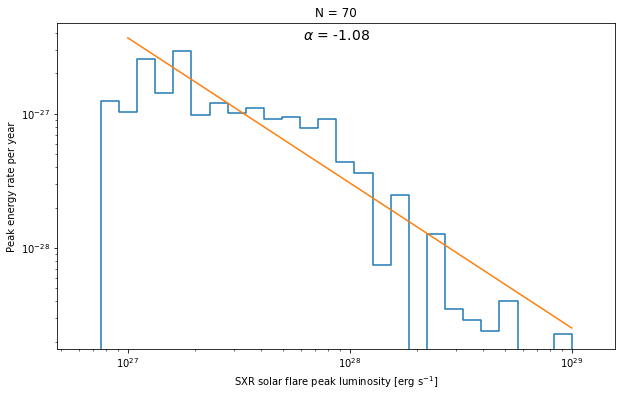

In [39]:
# Integrate spectra across energy to produce one value per time
irradiance = integrate_spectrum_energy(spectral_irradiance, energy) * (u.photon / u.second / u.centimeter**2)

# Choose the peak flare time
irradiance_peaks = []
for i in range(len(goes_start_jd)):
    peak_time_index = minxss_near_flare_peak(time_jd, goes_peak_jd[i], tolerance_pm_minutes=1)
    if peak_time_index is not np.nan:
        irradiance_peaks.append(irradiance[peak_time_index])
        
        
# Integrate over 1 AU to get rid of the / cm^2
photon_rate = integrate_photon_flux_1au(irradiance_peaks)

# Convert photons to energy
energy_rate = convert_photons_to_energy(energy, photon_rate)
energy_rate_array = np.array([e.value for e in energy_rate])

# Get histogram
bin_centers, dn_denergy_rate_per_year = compute_ffd(energy_rate_array)
num_events = len(energy_rate_array)

# Plot histogram and power law fit
plot_ffd_basic(bin_centers, dn_denergy_rate_per_year, len(energy_rate_array))
plt.xlabel('SXR solar flare peak luminosity [erg s$^{-1}$]')
plt.ylabel('Peak energy rate per year')
fit_slope(bin_centers, dn_denergy_rate_per_year, xmin=1e27, xmax=4e28)
plt.savefig('plots/Peak energy rate per year.png')